In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', None)

# Data Viz
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

# ML Models and Utils
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from mapie.classification import MapieClassifier

# Setup
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Custom Functions
from utils.data import summary
from utils.model import encoding_labels, train_calib_test_split, model_report
from utils.plot import plot_countplot, plot_intersections

# EDA & Preprocessing

Data taken from [Maven Churn Challenge](https://www.mavenanalytics.io/blog/maven-churn-challenge)

In [2]:
data_path = '../../../../data/telecom_churn'

df = pd.read_csv(f'{data_path}/telecom_customer_churn.csv')
data_population = pd.read_csv(f'{data_path}/telecom_zipcode_population.csv')
data_dict = pd.read_csv(f'{data_path}/telecom_data_dictionary.csv', encoding='ISO-8859-1')

data_dict

,Table,Field,Description
0,Customer Churn,CustomerID,A unique ID that identifies each customer
1,Customer Churn,Gender,"The customers gender: Male, Female"
2,Customer Churn,Age,"The customers current age, in years, at the time the fiscal quarter ended (Q2 2022)"
3,Customer Churn,Married,"Indicates if the customer is married: Yes, No"
4,Customer Churn,Number of Dependents,"Indicates the number of dependents that live with the customer (dependents could be children, parents, grandparents, etc.)"
5,Customer Churn,City,The city of the customers primary residence in California
6,Customer Churn,Zip Code,The zip code of the customers primary residence
7,Customer Churn,Latitude,The latitude of the customers primary residence
8,Customer Churn,Longitude,The longitude of the customers primary residence
9,Customer Churn,Number of Referrals,Indicates the number of times the customer has referred a friend or family member to this company to date


In [3]:
print('-'*45)
print('df')
summary(df, False)

print('-'*45)
print('population')
summary(data_population)

---------------------------------------------
df
-----------------
Data Types:
object     23
float64     9
int64       6
-----------------
Num Rows: 7043
Num Cols: 38
---------------------------------------------
population
-----------------
Data Types:
int64    2
-----------------
Num Rows: 1671
Num Cols: 2
            Total Null  Num Unique  Dtype
Zip Code             0        1671  int64
Population           0        1607  int64


## Spliting Data Types

In [4]:
location = ['City', 'Zip Code', 'Latitude', 'Longitude']
churn = ['Customer Status', 'Churn Category', 'Churn Reason']
drop = location + churn + ['Customer ID']

df_int = df.drop(drop, axis=1).select_dtypes(include='int')
df_float = df.drop(drop, axis=1).select_dtypes(include='float')
df_object = df.drop(drop, axis=1).select_dtypes(include='object')

df_city = df[location]
df_churn = df[churn]

for name, df_type in zip(('integer', 'float', 'object', 'city', 'churn'),
                         (df_int, df_float, df_object, df_city, df_churn)):
    
    print('-'*67)
    print(name)
    summary(df_type)

-------------------------------------------------------------------
integer
-----------------
Data Types:
int64    5
-----------------
Num Rows: 7043
Num Cols: 5
                          Total Null  Num Unique  Dtype
Age                                0          62  int64
Number of Dependents               0          10  int64
Number of Referrals                0          12  int64
Tenure in Months                   0          72  int64
Total Extra Data Charges           0          16  int64
-------------------------------------------------------------------
float
-----------------
Data Types:
float64    7
-----------------
Num Rows: 7043
Num Cols: 7
                                   Total Null  Num Unique    Dtype
Avg Monthly Long Distance Charges         682        3583  float64
Avg Monthly GB Download                  1526          49  float64
Monthly Charge                              0        1591  float64
Total Charges                               0        6540  float64
Total

## Investigating Nulls

### `df_object`

In [5]:
df_object['Internet Service'].value_counts()

Yes    5517
No     1526
Name: Internet Service, dtype: int64

In [6]:
df_object[df_object['Internet Service']=='No'].isna().sum()

Gender                       0
Married                      0
Offer                        0
Phone Service                0
Multiple Lines               0
Internet Service             0
Internet Type             1526
Online Security           1526
Online Backup             1526
Device Protection Plan    1526
Premium Tech Support      1526
Streaming TV              1526
Streaming Movies          1526
Streaming Music           1526
Unlimited Data            1526
Contract                     0
Paperless Billing            0
Payment Method               0
dtype: int64

In [7]:
print(pd.get_dummies(df_object, drop_first=False, prefix_sep=' - ').columns)
print('-'*80)
print(pd.get_dummies(df_object, drop_first=True, prefix_sep=' - ').columns)

Index(['Gender - Female', 'Gender - Male', 'Married - No', 'Married - Yes',
       'Offer - None', 'Offer - Offer A', 'Offer - Offer B', 'Offer - Offer C',
       'Offer - Offer D', 'Offer - Offer E', 'Phone Service - No',
       'Phone Service - Yes', 'Multiple Lines - No', 'Multiple Lines - Yes',
       'Internet Service - No', 'Internet Service - Yes',
       'Internet Type - Cable', 'Internet Type - DSL',
       'Internet Type - Fiber Optic', 'Online Security - No',
       'Online Security - Yes', 'Online Backup - No', 'Online Backup - Yes',
       'Device Protection Plan - No', 'Device Protection Plan - Yes',
       'Premium Tech Support - No', 'Premium Tech Support - Yes',
       'Streaming TV - No', 'Streaming TV - Yes', 'Streaming Movies - No',
       'Streaming Movies - Yes', 'Streaming Music - No',
       'Streaming Music - Yes', 'Unlimited Data - No', 'Unlimited Data - Yes',
       'Contract - Month-to-Month', 'Contract - One Year',
       'Contract - Two Year', 'Paperless B

#### Insights and Solutions

In `df_object` all `NaN` values are related to options included in a service (phone or internet) that the client does not have.

For linear models, they will all kindly disappear after one-hot encoding it with `pd.get_dummies`.

### `df_float`

In [8]:
df_float[df_object['Internet Service']=='No'].isna().sum()

Avg Monthly Long Distance Charges       0
Avg Monthly GB Download              1526
Monthly Charge                          0
Total Charges                           0
Total Refunds                           0
Total Long Distance Charges             0
Total Revenue                           0
dtype: int64

In [9]:
df_float['Avg Monthly GB Download'].describe()

count    5517.000000
mean       26.189958
std        19.586585
min         2.000000
25%        13.000000
50%        21.000000
75%        30.000000
max        85.000000
Name: Avg Monthly GB Download, dtype: float64

In [10]:
df_object['Phone Service'].value_counts()

Yes    6361
No      682
Name: Phone Service, dtype: int64

In [11]:
df_float[df_object['Phone Service']=='No'].isna().sum()

Avg Monthly Long Distance Charges    682
Avg Monthly GB Download                0
Monthly Charge                         0
Total Charges                          0
Total Refunds                          0
Total Long Distance Charges            0
Total Revenue                          0
dtype: int64

In [12]:
df_float['Avg Monthly Long Distance Charges'].describe()

count    6361.000000
mean       25.420517
std        14.200374
min         1.010000
25%        13.050000
50%        25.690000
75%        37.680000
max        49.990000
Name: Avg Monthly Long Distance Charges, dtype: float64

#### Insights and Solutions

Similar to `df_object`, the `NaN` values here are also related to not having a service.

For linear models they will be filled with `0`

### `df_churn`

In [13]:
df_churn['Customer Status'].value_counts()

Stayed     4720
Churned    1869
Joined      454
Name: Customer Status, dtype: int64

In [14]:
df_churn[~df_churn['Churn Category'].isna()]['Customer Status'].value_counts()

Churned    1869
Name: Customer Status, dtype: int64

In [15]:
df_churn[~df_churn['Churn Reason'].isna()]['Customer Status'].value_counts()

Churned    1869
Name: Customer Status, dtype: int64

#### Insights and Solutions

The `NaN` in `Churn Category` and `Churn Reason` are there when `Customer Status != Churned`

They can be filled accordingly if used as targets.

## Class Balance

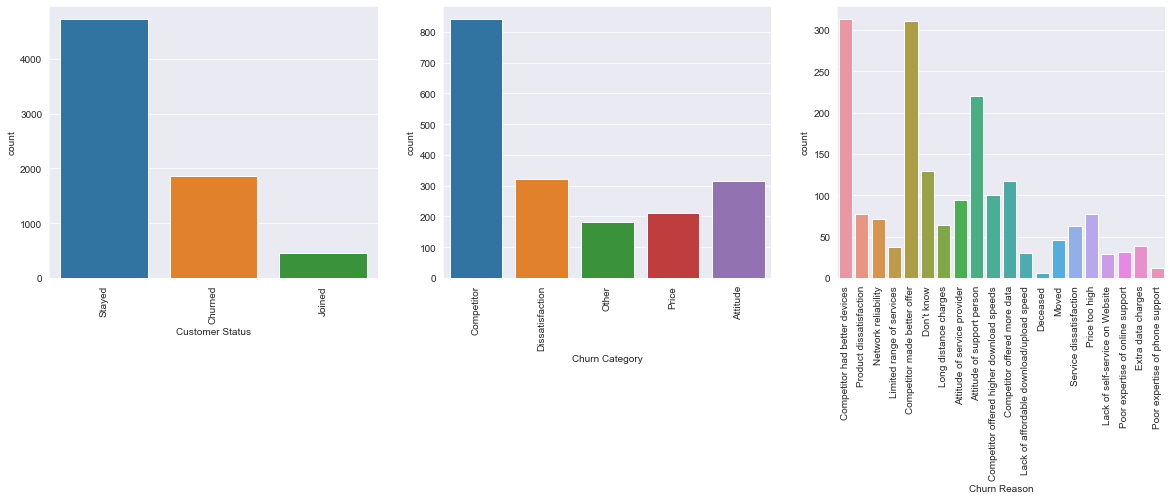

In [16]:
plot_countplot(df_churn, fig_cols=3, figsize=(20, 5), rotation=90)

In [17]:
df_churn['Churn Category'].value_counts()

Competitor         841
Dissatisfaction    321
Attitude           314
Price              211
Other              182
Name: Churn Category, dtype: int64

In [18]:
df_churn.value_counts(dropna=False).sort_index()

Customer Status  Churn Category   Churn Reason                             
Churned          Attitude         Attitude of service provider                   94
                                  Attitude of support person                    220
                 Competitor       Competitor had better devices                 313
                                  Competitor made better offer                  311
                                  Competitor offered higher download speeds     100
                                  Competitor offered more data                  117
                 Dissatisfaction  Lack of self-service on Website                29
                                  Limited range of services                      37
                                  Network reliability                            72
                                  Poor expertise of online support               31
                                  Poor expertise of phone support                12


#### Insights and Solutions

LOREM IPSUM

# Conformal Prediction - Demonstration

In [19]:
# Data Split
X = pd.concat([df_int, df_float, df_object.fillna('null').astype('category')], axis=1)
y = df_churn['Customer Status']
y, y_encoder = encoding_labels(y)

X_train, X_calib, X_test, y_train, y_calib, y_test= train_calib_test_split(X, y)
report = model_report(X_test, y_test, y_encoder, 'classifier')

<class 'sklearn.preprocessing._label.LabelEncoder'>


## LightGBM Classifier

### Model

In [20]:
# Model
lgb = LGBMClassifier(n_estimators=1000, random_state=357)
lgb.fit(X_train, y_train,
        eval_set=[(X_calib, y_calib), (X_train, y_train)],
        categorical_feature=list(df_object.columns),
        callbacks=[early_stopping(100), log_evaluation(10)]);

Training until validation scores don't improve for 100 rounds
[10]	training's multi_logloss: 0.36754	valid_0's multi_logloss: 0.433223
[20]	training's multi_logloss: 0.26531	valid_0's multi_logloss: 0.378231
[30]	training's multi_logloss: 0.212746	valid_0's multi_logloss: 0.365174
[40]	training's multi_logloss: 0.178629	valid_0's multi_logloss: 0.364762
[50]	training's multi_logloss: 0.153096	valid_0's multi_logloss: 0.368968
[60]	training's multi_logloss: 0.132333	valid_0's multi_logloss: 0.374307
[70]	training's multi_logloss: 0.115196	valid_0's multi_logloss: 0.37766
[80]	training's multi_logloss: 0.101504	valid_0's multi_logloss: 0.385876
[90]	training's multi_logloss: 0.0887914	valid_0's multi_logloss: 0.3938
[100]	training's multi_logloss: 0.0778505	valid_0's multi_logloss: 0.401985
[110]	training's multi_logloss: 0.0675574	valid_0's multi_logloss: 0.408544
[120]	training's multi_logloss: 0.0589017	valid_0's multi_logloss: 0.416115
[130]	training's multi_logloss: 0.0514534	valid_

[0 1 2]
['Churned' 'Joined' 'Stayed']
----------------------Classification Report----------------------
              precision    recall  f1-score   support

     Churned       0.72      0.68      0.70       390
      Joined       0.69      0.68      0.69        90
      Stayed       0.90      0.92      0.91       929

    accuracy                           0.84      1409
   macro avg       0.77      0.76      0.76      1409
weighted avg       0.83      0.84      0.84      1409



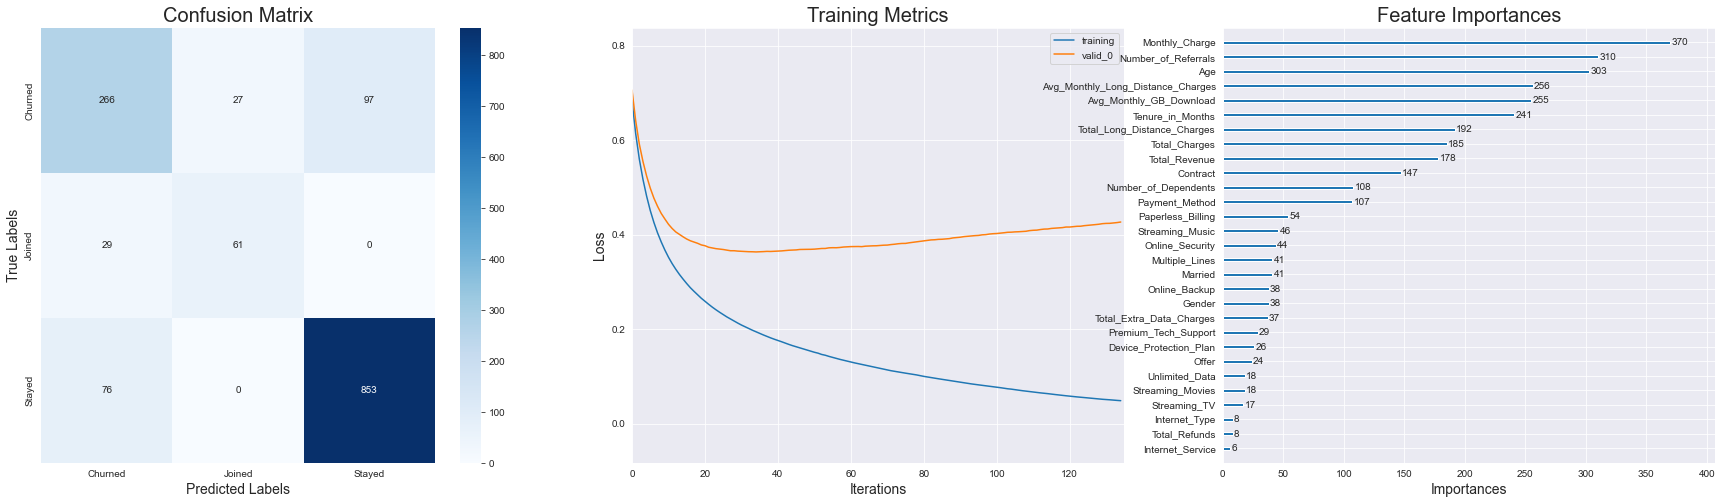

In [21]:
report.lightgbm_classifier(lgb)

### Calibration

In [22]:
conformal_lgb = MapieClassifier(estimator=lgb, cv="prefit", method="score", random_state=357, verbose=True)
conformal_lgb.fit(X_calib, y_calib);

----------------------Calibration Report----------------------
test size: 1409
uncalibrated accuracy: 83.75 %
-----------------
alpha: 0.2
coverage: 81.55 %
empty sets: 71
unit sets: 1338
other sets: 0
-----------------
alpha: 0.15
coverage: 86.52 %
empty sets: 0
unit sets: 1337
other sets: 72
-----------------
alpha: 0.1
coverage: 90.77 %
empty sets: 0
unit sets: 1191
other sets: 218
-----------------
alpha: 0.05
coverage: 95.1 %
empty sets: 0
unit sets: 952
other sets: 457


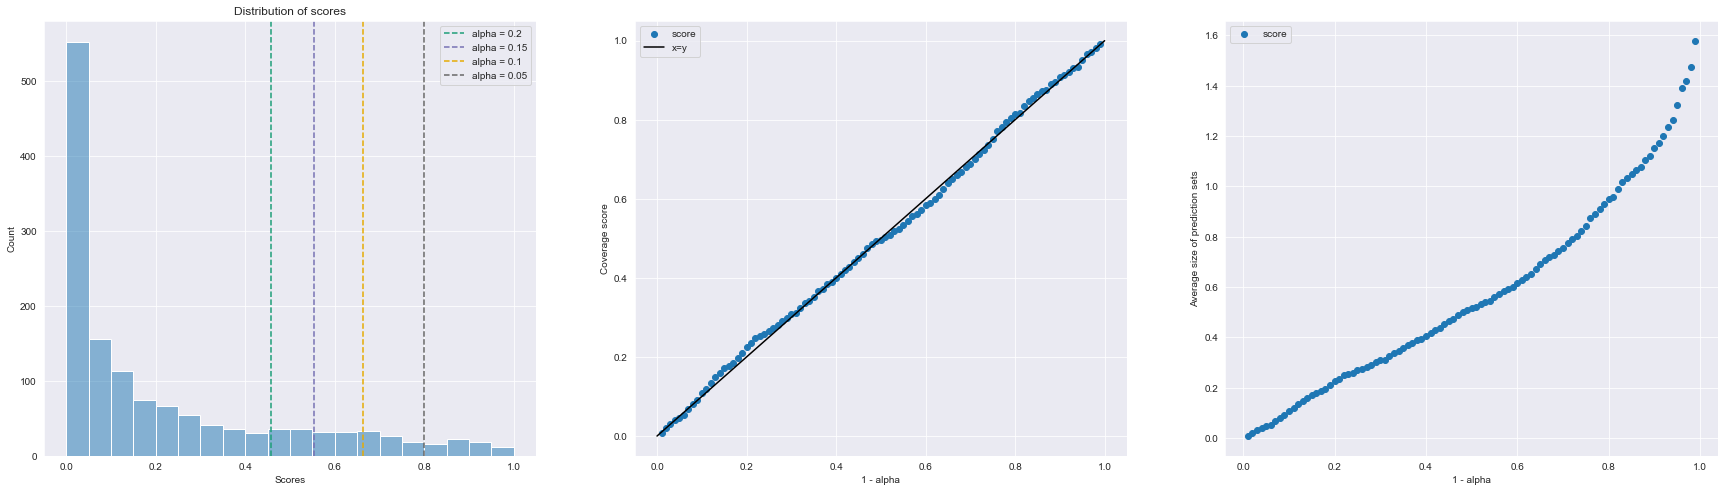

In [23]:
report.calibration_report(conformal_lgb)

### Set Intersections

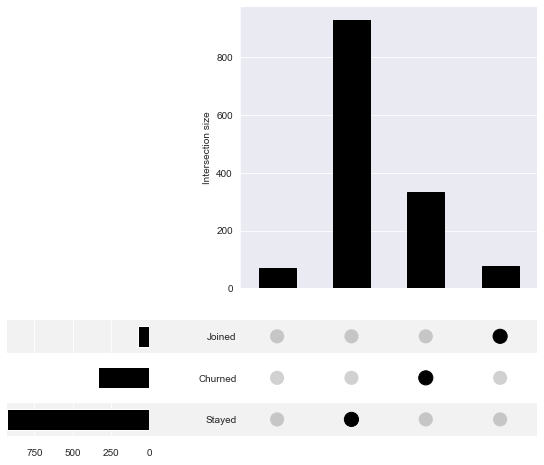

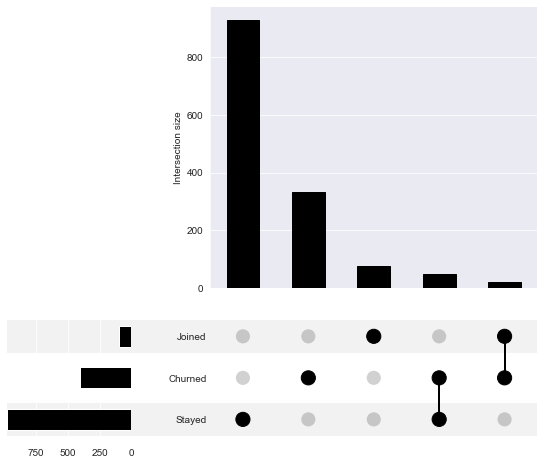

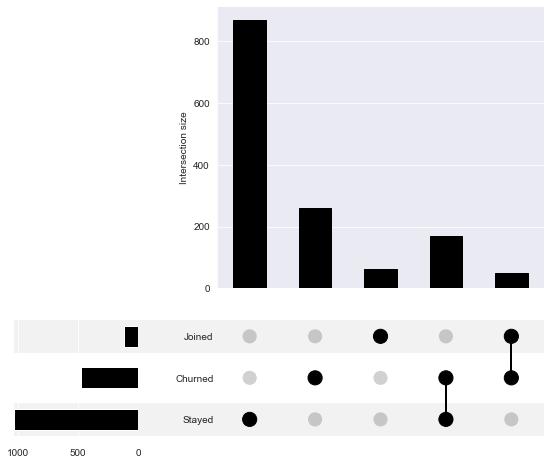

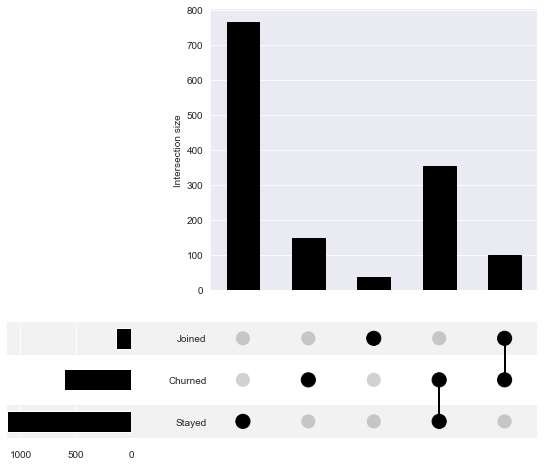

In [31]:
_, y_pred_conformal = conformal_lgb.predict(X_test, alpha=[0.2, 0.15, 0.1, 0.05])
plot_intersections(y_pred_conformal, y_encoder.inverse_transform(lgb.classes_), [0.25, 0.15, 0.1, 0.05])

## CatBoost Classifier

### Model

In [26]:
# # Data Split
# X = pd.concat([df_int, df_float, df_object.fillna('null').astype('category')], axis=1)
# y = df_churn['Customer Status']
# y, y_encoder = encoding_labels(y)

# X_train, X_calib, X_test, y_train, y_calib, y_test = train_calib_test_split(X, y)

# # Model
# cat = CatBoostClassifier(random_state=357)
# cat.fit(X_train, y_train,
#         eval_set=[(X_calib, y_calib)],
#         cat_features=list(df_object.columns),
#         early_stopping_rounds=100, verbose=25, plot=True);

# from sklearn.metrics import classification_report, confusion_matrix

# y_pred = cat.predict(X_test)

# print('----------------------Classification Report----------------------')
# print(classification_report(y_encoder.inverse_transform(y_test), y_encoder.inverse_transform(y_pred)))


# labels = y_encoder.inverse_transform(cat.classes_)

# fig, ax = plt.subplots(figsize=(10, 8))
# sns.heatmap(
#     confusion_matrix(y_test, y_pred),
#     xticklabels=labels, yticklabels=labels,
#     annot=True, cmap='Blues', fmt='g',
# );

In [27]:
# from sklearn.metrics import classification_report, confusion_matrix

# y_pred = cat.predict(X_test)

# print('----------------------Classification Report----------------------')
# print(classification_report(y_encoder.inverse_transform(y_test), y_encoder.inverse_transform(y_pred)))


# labels = y_encoder.inverse_transform(cat.classes_)

# fig, ax = plt.subplots(figsize=(10, 8))
# sns.heatmap(
#     confusion_matrix(y_test, y_pred),
#     xticklabels=labels, yticklabels=labels,
#     annot=True, cmap='Blues', fmt='g',
# );

### Calibration

In [28]:
# from mapie.classification import MapieClassifier

# conformal_cat = MapieClassifier(estimator=cat, cv="prefit", method="score", random_state=357, verbose=True)
# conformal_cat.fit(X_calib, y_calib)
# alphas = [0.2, 0.15, 0.1, 0.05]
# y_pred, y_pred_conformal = conformal_cat.predict(X_test, alpha=alphas)

# for k, a in enumerate(alphas):
#     count = 0
#     for i, j in enumerate(y_test):
#         if y_pred_conformal[i, j, k]:
#             count += 1
    
#     print('-----------------')
#     print('alpha:', a)
#     print('coverage:', round((count / len(y_test))*100, 2), '%')

# calibration_report(X_test, y_test, conformal_cat, alphas)

### Set Intersections

In [29]:
# plot_intersections(y_pred_conformal, y_encoder.inverse_transform(cat.classes_), alphas)